In [225]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from vis_common import load_store, load_games

store = load_store()
games = load_games()
g = games

In [61]:
FS = (10, 6) # Reasonable default figsize

In [92]:
print "{} distinct players among {} games".format(
    g['pid'].unique().shape[0], len(g)
)

26011 distinct players among 1327938 games


TODO: better way to assign winrates to players than just maximum-likelihood? Additive smoothing? Confidence intervals?

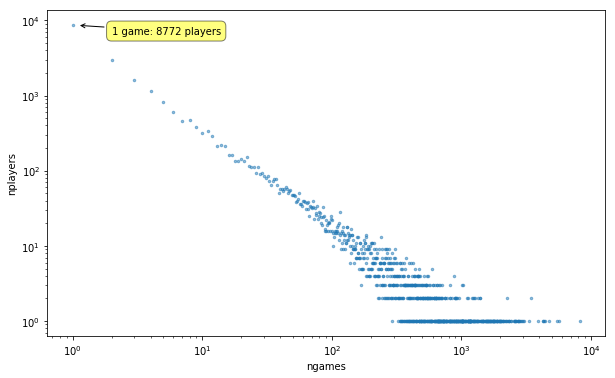

In [60]:
# How many games per player?
count_counts = g.groupby('pid').size().value_counts().to_frame('nplayers')
count_counts['ngames'] = count_counts.index
fig, ax = plt.subplots(figsize=FS)
ax.scatter(count_counts['ngames'], count_counts['nplayers'], marker='.', s=25, alpha=.5)
onegame = count_counts.loc[1]['nplayers']
ax.annotate("1 game: {} players".format(onegame), 
            xy=(1.1, onegame*.98), xytext=(2, onegame*.75),
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
           )
ax.set_xlabel('ngames')
ax.set_ylabel('nplayers')
ax.loglog();

48.6% of players have more than 2 games


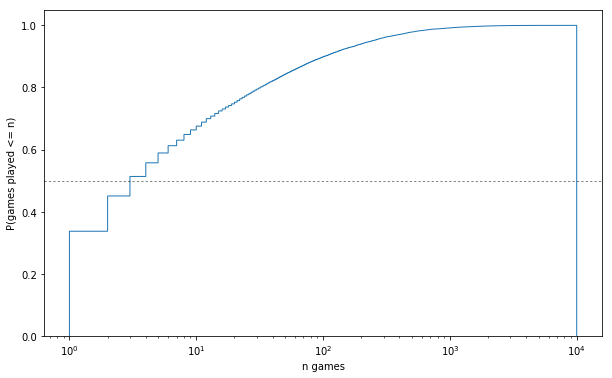

In [88]:
fig, ax = plt.subplots(figsize=FS)
counts = g.groupby('pid').size().values
n, bins, patches = ax.hist(counts, 
                           np.arange(1, 10**4),
                           #np.logspace(0, 4, 150),
       normed=1, histtype='step', cumulative=1
)
midpoint = (n >= .5).argmax()
midpct = 100 * n[midpoint]
ax.set_xscale('log');
ax.axhline(y=.5, color='black', linestyle=':', linewidth=.5);
ax.set_xlabel('n games')
ax.set_ylabel('P(games played <= n)');
print '{:.1f}% of players have more than {} games'.format(
    100-midpct, midpoint)

In [90]:
print "Distribution of games player per player"
g.groupby('pid').size().describe([.25, .5, .75, .9, .99])

count    26011.000000
mean        51.052939
std        202.004039
min          1.000000
25%          1.000000
50%          3.000000
75%         20.000000
90%        102.000000
99%        879.000000
max       8170.000000
dtype: float64

In [94]:
wpp = wins_per_pid = g.groupby('pid')['won'].sum()
wpp = wins_per_pid
print "{} players have won at least one game".format(
    (wpp > 0).sum()
)
winpids = wpp.where(lambda wins: wins > 0).dropna().index

2115 players have won at least one game


In [96]:
# Do winners account for more games? Probably!
print "Dist of games played among winners"
g[g['pid'].isin(winpids)].groupby('pid').size().describe([.1, .25, .5, .75, .9])

count    2115.000000
mean      306.066194
std       516.177574
min         1.000000
10%         9.000000
25%        39.000000
50%       130.000000
75%       357.000000
90%       752.600000
max      8170.000000
dtype: float64

In [161]:
print "{} out of {} games are played by players who have won a game".format(
    g['pid'].isin(winpids).sum(), len(g)
)

647330 out of 1327938 games are played by players who have won a game


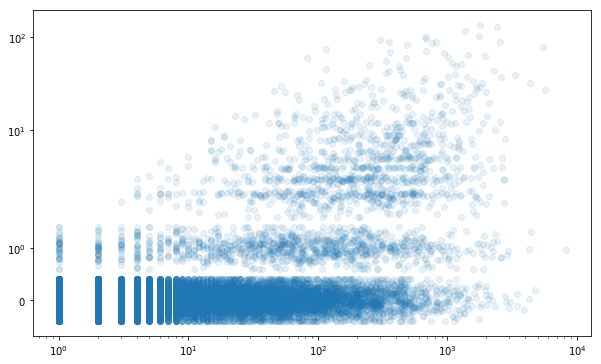

In [121]:
gpp = games_per_pid = g.groupby('pid').size()
fig, ax = plt.subplots(figsize=FS)
wins = wpp[gpp.index].values
clamp = .4
winjitter = np.minimum(np.ones_like(wins)*clamp,
                       np.random.randn(len(gpp)) * .2
                      )
winjitter = np.maximum(np.ones_like(winjitter)*-clamp, winjitter)
ax.scatter(gpp.values, wins + winjitter,
           alpha=.1,
)
ax.set_yscale('symlog')
ax.set_xscale('log')
#ax.set_ylim(1, 10**3);
# TODO: try hexbins?

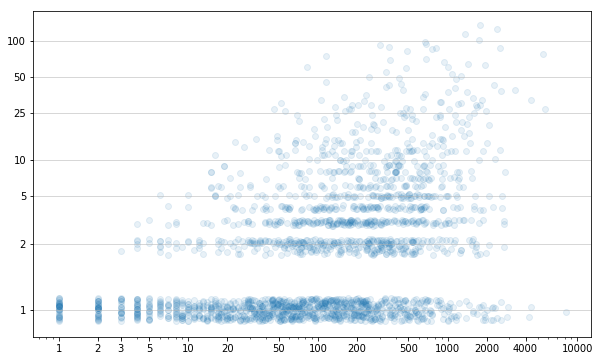

In [146]:
gpp = games_per_pid = g.groupby('pid').size()
fig, ax = plt.subplots(figsize=FS)
wins = wpp.loc[winpids].values
clamp = 1
winjitter = np.minimum(np.ones_like(wins)*clamp,
                       #np.random.randn(*wins.shape) * .05
                       (np.random.rand(*wins.shape)-.5) * .35
                      )
winjitter = np.maximum(np.ones_like(winjitter)*-clamp, winjitter)
ax.scatter(gpp.loc[winpids].values, wins + winjitter,
           alpha=.1,
)
ax.set_yscale('symlog')
ax.set_xscale('log')
gameticks = [1, 2, 3, 5, 10, 20, 50, 100, 200, 
                          500, 1000, 2000, 4000,
                          10000]
winticks = [1, 2, 5, 10, 25, 50, 100]
ax.set_xticks(gameticks)
ax.set_yticks(winticks);
ax.set_xticklabels([str(i) for i in gameticks])
ax.set_yticklabels([str(i) for i in winticks]);
ax.grid(axis='y', lw=.5);

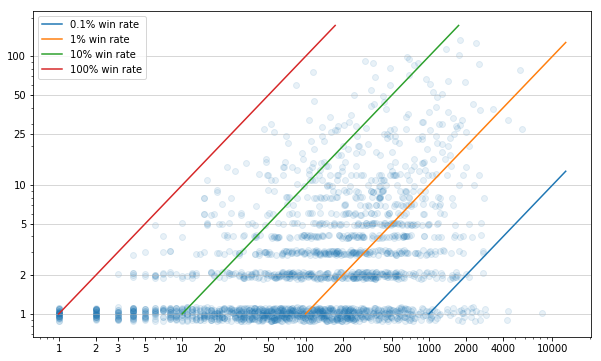

In [159]:
gpp = games_per_pid = g.groupby('pid').size()
fig, ax = plt.subplots(figsize=FS)
wins = wpp.loc[winpids].values
jitterstr = .25
winjitter = (np.random.rand(*wins.shape)-.5) * jitterstr
ax.scatter(gpp.loc[winpids].values, wins + winjitter,
           alpha=.1,
)
#ax.set_yscale('symlog')
#ax.set_xscale('log')
ax.loglog() # Can get away with this now that we're rid of the losers
gameticks = [1, 2, 3, 5, 10, 20, 50, 100, 200, 
                          500, 1000, 2000, 4000,
                          10000]
winticks = [1, 2, 5, 10, 25, 50, 100]
ax.set_xticks(gameticks)
ax.set_yticks(winticks);
ax.set_xticklabels([str(i) for i in gameticks])
ax.set_yticklabels([str(i) for i in winticks]);
ax.grid(axis='y', lw=.5);
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ymin = 1
for wr in [.001, .01, .1, 1.0]:
    p1 = [ymin/wr, ymin]
    if xmax*wr <= ymax:
        p2 = [xmax, xmax*wr]
    else:
        p2 = [ymax/wr, ymax]
    xs, ys = zip(p1, p2)
    ax.plot(xs,
            ys,
            label=('{}% win rate'.format(int(wr*100)) if wr >= .01
                   else '{:.1f}% win rate'.format(wr*100))
    )
ax.legend();
# TODO: colormap lines?

In [168]:
# Maybe this gives us some intuition about how we might define
# some thresholds for good/great/bad players

winpids = wpp.where(lambda wins: wins > 0).dropna().index
iwinner = g['pid'].isin(winpids)
#noobs = wpp.where(lambda wins: wins == 0).dropna().index
inoob = ~iwinner

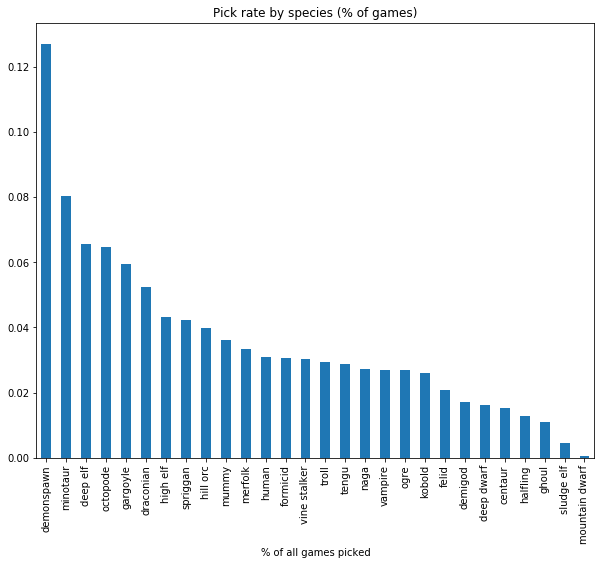

In [166]:
# Reminder
pr = (g.groupby('orig_species').size() / len(g)).\
    sort_values(ascending=False)
ax = pr.plot.bar(title='Pick rate by species (% of games)', 
                 figsize=(10,8));
ax.set_xlabel('% of all games picked');

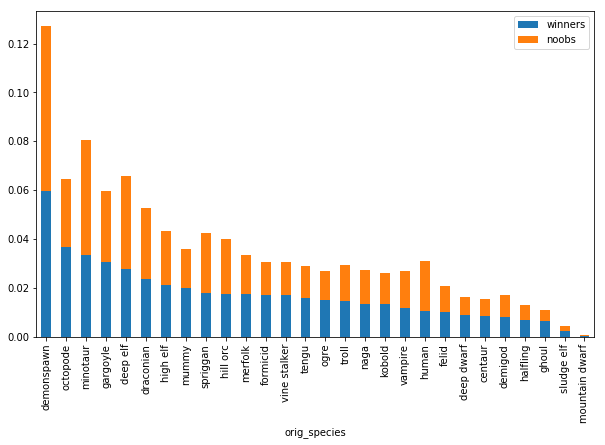

In [179]:
pr_winners = (g[iwinner].groupby('orig_species').size() / len(g))\
    .sort_values(ascending=False).rename('winners')
idx = pr_winners.index
pr_noobs = (g[inoob].groupby('orig_species').size() / len(g))
pr_noobs = pr_noobs.loc[idx].rename('noobs')
combined = pd.DataFrame([pr_winners, pr_noobs]).T
combined.plot.bar(figsize=FS, stacked=1);
# TODO: add a line to each bar at the point where the junction
# should be according to the overall winner/noob proportion.
# probably tricky to do

In [185]:
c2 = combined.copy()
# Proportion of this species' games played by a winning player
winnerratio = (c2['winners'] / (c2['noobs'] + c2['winners']))
baseline_ratio = iwinner.sum() / len(g)
c2['winnerscore'] = winnerratio - baseline_ratio
c2 = c2.sort_values(by='winnerscore', ascending=0)
print "Expert species"
c2.head(10)
# This kiiinda supports the DD as newb repellant theory
# But contradicts octopodes as newb magnets

Expert species


,winners,noobs,winnerscore
orig_species,,,
mountain dwarf,0.000364,0.000215,0.141101
ghoul,0.006387,0.004536,0.097294
ogre,0.015244,0.011528,0.081937
octopode,0.036762,0.027811,0.081838
centaur,0.008603,0.006670,0.075788
formicid,0.017224,0.013413,0.074717
vine stalker,0.017014,0.013421,0.071566
mummy,0.020131,0.015932,0.070747
tengu,0.016049,0.012791,0.069008


In [188]:
print "Noob species"
c2.iloc[::-1].head(10)

Noob species


,winners,noobs,winnerscore
orig_species,,,
human,0.010537,0.020332,-0.146127
minotaur,0.033464,0.046941,-0.071279
spriggan,0.017947,0.024388,-0.063549
deep elf,0.027857,0.037740,-0.062795
vampire,0.011592,0.015267,-0.055895
hill orc,0.017446,0.022485,-0.050571
draconian,0.023796,0.028733,-0.034470
demigod,0.008012,0.009056,-0.018068
demonspawn,0.059832,0.067306,-0.016863


In [198]:
wrpp = winrate_per_pid = g.groupby('pid')['won'].mean()
print "Distribution of non-zero win %s among players"
(100*wrpp[wrpp > 0]).describe()

Distribution of non-zero win %s among players


count    2115.000000
mean        7.433725
std        16.032512
min         0.012240
25%         0.699301
50%         1.886792
75%         5.882353
max       100.000000
Name: won, dtype: float64

In [202]:
# What if we use a slightly more liberal definition of noob?
# Bottom decile of winners ranked by win rate?
newbish_wr = wrpp[wrpp > 0].quantile(.1)
infreq = (wrpp > 0) & (wrpp <= newbish_wr)
print "picked {} infrequent winners out of {} (vs. {} non-winners)".format(
    infreq.sum(), len(winpids), g['pid'].unique().shape[0]
)
print "infrequent winners played {} games (out of {} winner games)".format(
    g['pid'].isin(infreq.index).sum(), iwinner.sum()
)
newbish_pids = wrpp[wrpp <= newbish_wr].index
inewbish = g['pid'].isin(newbish_pids)

print "Adding infrequent winners increases newb games from {} to {}"\
    .format(inoob.sum(), inewbish.sum())

picked 212 infrequent winners out of 2115 (vs. 26011 non-winners)
infrequent winners played 1327938 games (out of 647330 winner games)
Adding infrequent winners increases newb games from 680608 to 905590


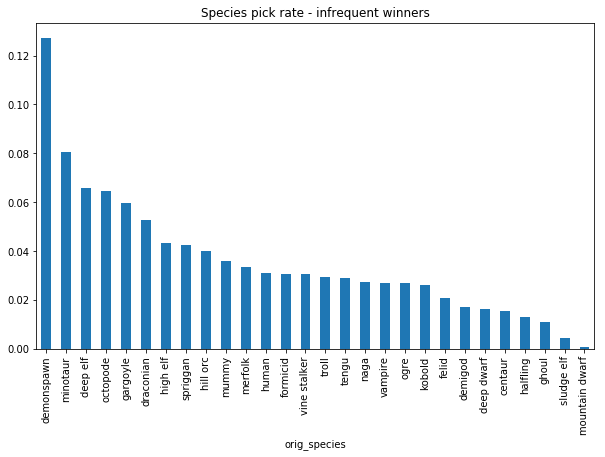

In [227]:
iinfreq = g['pid'].isin(infreq.index)
ax = (g[iinfreq].groupby('orig_species').size()/iinfreq.sum())\
    .sort_values(ascending=False)\
    .plot.bar(figsize=FS, 
              title='Species pick rate - infrequent winners')

In [205]:
pr_winners = (g[~inewbish].groupby('orig_species').size() / len(g))\
    .sort_values(ascending=False).rename('winners')
idx = pr_winners.index
pr_noobs = (g[inewbish].groupby('orig_species').size() / len(g))
pr_noobs = pr_noobs.loc[idx].rename('noobs')
combined = pd.DataFrame([pr_winners, pr_noobs]).T
c2 = combined
# Proportion of this species' games played by a winning player
winnerratio = (c2['winners'] / (c2['noobs'] + c2['winners']))
baseline_ratio = (~inewbish).sum() / len(g)
c2['winnerscore'] = winnerratio / baseline_ratio
c2 = c2.sort_values(by='winnerscore', ascending=0)
c2

,winners,noobs,winnerscore
orig_species,,,
ghoul,0.004750,0.006173,1.367355
tengu,0.011699,0.017142,1.275389
sludge elf,0.001803,0.002709,1.256203
formicid,0.012157,0.018480,1.247656
mummy,0.014254,0.021810,1.242703
ogre,0.010376,0.016395,1.218634
deep dwarf,0.006261,0.010010,1.209882
demigod,0.006430,0.010638,1.184426
centaur,0.005720,0.009553,1.177556


In [264]:
# TWODO: so there's gotta be a better way to do this kind of
# thing in one group by (grouping by e.g. species ~and~ newb vs.
# winner)
# The goggles do nothing.
foo = g.groupby(['orig_species', inewbish]).size().rename('count');

905590
422348


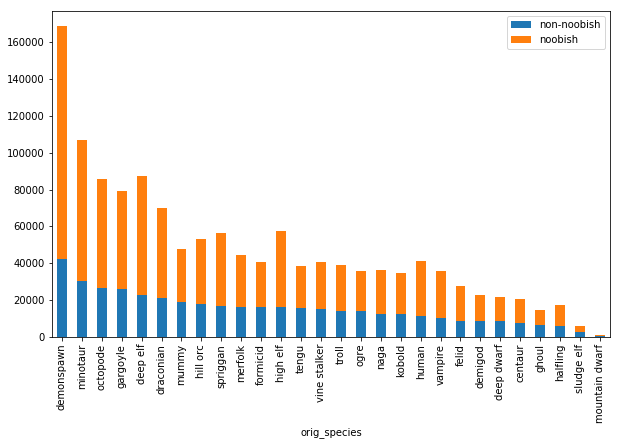

In [267]:
roo = foo.reset_index(level=1)
poo = roo.pivot(columns='pid', values='count')
poo.columns = ['non-noobish', 'noobish']
poo = poo.sort_values(by='non-noobish', ascending=0)
poo.plot.bar(stacked=True, figsize=FS);

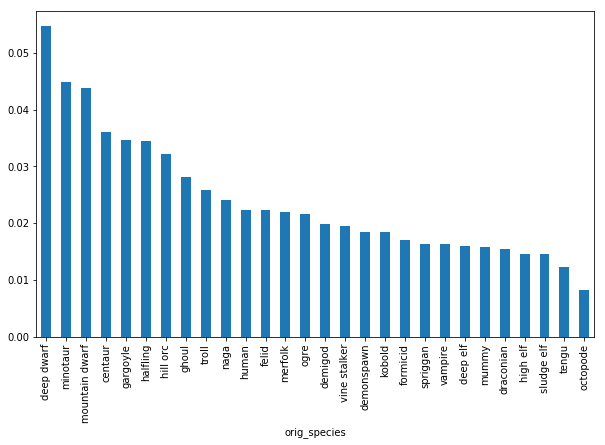

In [270]:
# Win rate per species among non-noobs
g[~inewbish].groupby('orig_species')['won'].mean()\
    .sort_values(ascending=0)\
    .plot.bar(figsize=FS);

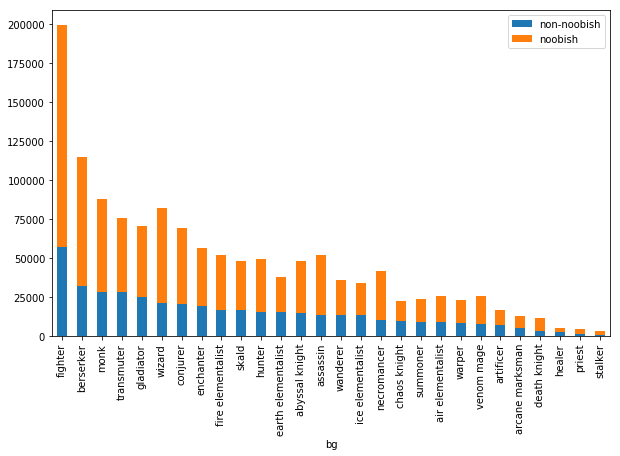

In [271]:
# TODO: refactor me into a fun-ction
foo = g.groupby(['bg', inewbish]).size().rename('count')\
    .reset_index(level=1).pivot(columns='pid', values='count');
foo.columns = ['non-noobish', 'noobish']
foo = foo.sort_values(by='non-noobish', ascending=0)
foo.plot.bar(stacked=True, figsize=FS);

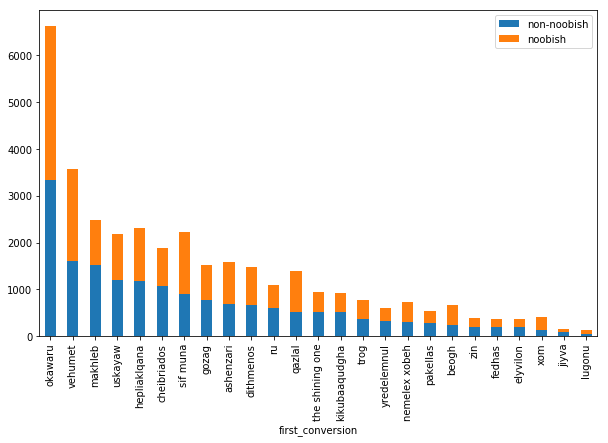

In [274]:
# Gods change a lot with the seasons. Let's fix one version for this.
foo = g[g['version']==0.19].groupby(['first_conversion', inewbish]).size().rename('count')\
    .reset_index(level=1).pivot(columns='pid', values='count');
foo.columns = ['non-noobish', 'noobish']
foo = foo.sort_values(by='non-noobish', ascending=0)
foo.plot.bar(stacked=True, figsize=FS);